# Project 1: Linear Regression

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload

In [2]:
# Importing standard libraries
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Importing project-specific files
from DataFunctions import FrankeFunction
from LinearRegression import OLS_matrix_inversion, ridge_regression, lasso_regression
from MLFunctions import bias_variance_tradeoff, DesignMatrix, cross_validation
from Statistics import MSE, R2

In [4]:
font = {'size'   : 14}

mpl.rc('font', **font)

In [76]:
# Defining data set
step_size = 0.05 # 0.025
arr = np.arange(0, 1, step_size)

Mat = np.meshgrid(arr, arr)
y = FrankeFunction(*Mat, noise=0)
np.size(y)

400

## Part a): Ordinary Least Square (OLS) on the Franke function
### Performing standard least square regression, and plotting the result.

In [77]:
X = DesignMatrix(arr, arr, 5)               # defining design matrix
beta_inv = OLS_matrix_inversion(X, y)       # computing polynomal coefficients usnig matrix inversion
model = X @ beta_inv

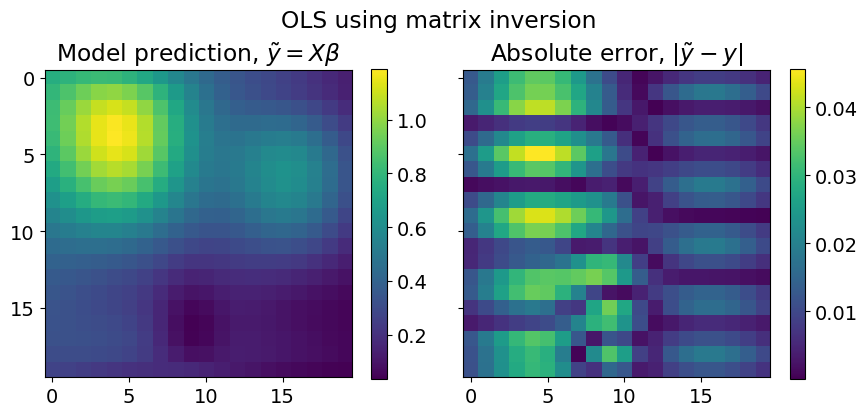

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("OLS using matrix inversion")
im0 = ax[0].imshow(model)
im1 = ax[1].imshow(abs(y - model))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()
fig.savefig("figs/OLS_matrix_inversion.pdf")

**Left plot:** Using matrix inversion to predict model of the Franke function without noise.  
**Right plot:** Absolute difference between model prediction and actual data.

In [79]:
# Computing errors
mse = MSE(y, model)
r2 = R2(y, model)

print(f"Mean-square-error: {mse:0.6f}\nR^2 score function: {r2:0.6f}")

Mean-square-error: 0.000336
R^2 score function: 0.995886


The mean square error is very low, and the $R^2$ score function is close to 1, so our model is pretty good...

### Now, we split our data in sets of training data and testing data
Here, we want to discuss ways to scale and split data. Use between 0.6-0.8 of data as training data.

In [80]:
test_sizes = np.linspace(0.05, 0.95, 20)
MSE_arr= np.zeros_like(test_sizes)
R2_arr = np.zeros_like(test_sizes)

reps = 1000
for rep in range(reps):
    i = 0

    for test_size in test_sizes:
        X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=test_size)
        beta = OLS_matrix_inversion(X_train, y_train)

        y_pred = X_test @ beta
        MSE_arr[i] = MSE_arr[i] + MSE(y_test, y_pred) / reps
        R2_arr[i] = R2_arr[i] + R2(y_test, y_pred) / reps

        i += 1

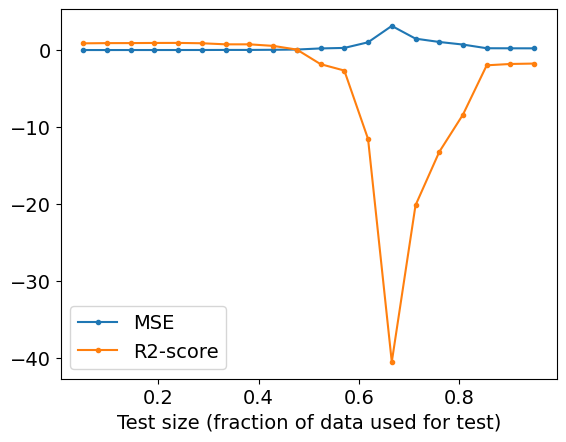

In [81]:
fig, ax = plt.subplots(1, 1)

ax.plot(test_sizes, MSE_arr, '.-', label="MSE")
ax.plot(test_sizes, R2_arr, '.-', label="R2-score")

ax.set(xlabel="Test size (fraction of data used for test)")
ax.set(yscale="linear")
ax.legend()

fig.savefig("figs/mse_r2_vs_testsize.pdf")

Not surprisingly, the mean square error increases with the test size, whereas the R2 score decreases with etst size.

## Part b): Bias-variance trade-off and resamplng techniques
### First, makeing figure of prediction error vs model complexity, for test and training models

In [82]:
Nreps = 100
max_degree = 20
test_size = 1/4

In [83]:
# empty arrays for storing result
MSE_train = np.zeros(max_degree)
MSE_test = np.zeros(max_degree)


# looping through complexity
for i in range(max_degree):
    X = DesignMatrix(arr, arr, i)

    # looping through repetitions
    for rep in range(Nreps):
        # performing OLS
        r = int(100 * np.random.rand())
        X_, X_test, y_, y_test = train_test_split(X, y, test_size=test_size, random_state=r)
        beta = OLS_matrix_inversion(X_, y_)

        # computing average
        MSE_train[i] += MSE(y_, X_ @ beta) / Nreps
        MSE_test[i] += MSE(y_test, X_test @ beta) / Nreps

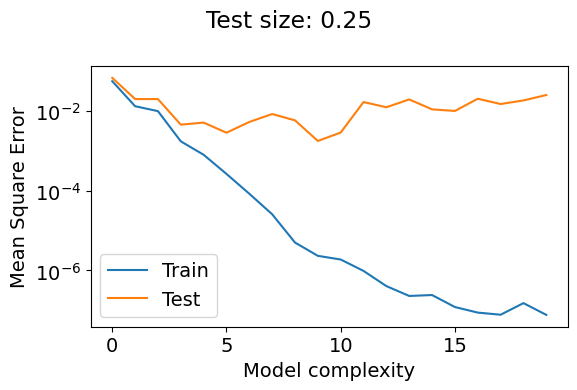

In [84]:
complexity = np.arange(max_degree)

fig, ax = plt.subplots(1,1, figsize=(6,4))
fig.suptitle(f"Test size: {test_size}")

ax.set(xlabel="Model complexity", ylabel="Mean Square Error", yscale="log")
ax.plot(complexity, MSE_train, label="Train")
ax.plot(complexity, MSE_test, label="Test")
ax.legend()

fig.tight_layout()
fig.savefig("figs/mse_test_train.pdf")

Whereas the error decreases with model complexity for the training data, the error on the test data increases at some point because of overtraining.
N.B.: here we have not yet used bootstrapping.

### Bias-variance analysis
The mean square error can be written as:
$E\left[(\mathbf{y} - \mathbf{\tilde{y}})^2\right] = \frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2 + \frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 + \sigma^2$.

The first term, $\frac{1}{n}\sum_i (y_i - E[\tilde{\mathbf{y}}])^2$, is the square of the bias, because it is the difference between data points and prediction average, i.e. a measure of how far the center of our model is from the actual data it is trying to capture.

The second term, $\frac{1}{n}\sum_i (\tilde{y_i} - E[\tilde{\mathbf{y}}])^2 = E[\tilde{\mathbf{y}}^2] - E[\tilde{\mathbf{y}}]^2$, is the variance, which can be seen mathematically, or by realising that it is the mean squared error of our model.

### Performing the bias-variance analysis

In [148]:
n_bootstraps = 50
max_degree = 21
test_size = 1/4

error_ols, bias2_ols, variance_ols = bias_variance_tradeoff(y, arr, n_bootstraps=n_bootstraps, max_degree=max_degree, test_size=test_size)

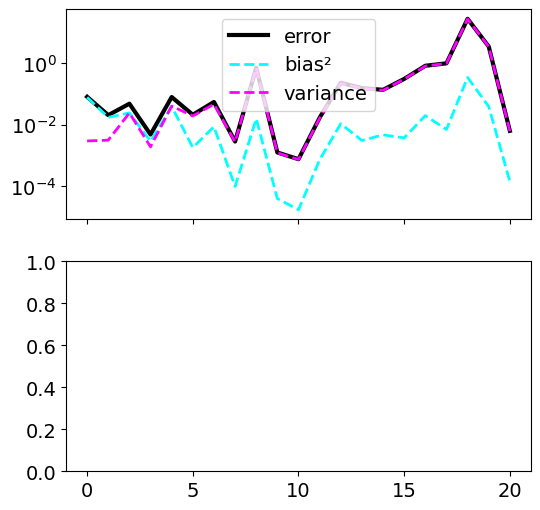

In [149]:
fig, ax = plt.subplots(2,1, figsize=(6, 6), sharex=True)
ax[0].plot(error_ols, "k-", lw=3, label="error")
ax[0].plot(bias2_ols, "--", color="cyan", lw=2, label="bias²")
ax[0].plot(variance_ols, "--", color="magenta", lw=2, label="variance")
ax[0].set(yscale="log")
ax[0].legend()

Something is off here. Problem seems to come from resampling, since when modifying code generating MSE-figure it behaves similarily. Is bootstrapping implemented wrong?

## Part c): Cross-validation and resampling techniques
### Scale data
Discussion?

### Implement the k-fold cross-validation algorithm

In [150]:
lmbd = 0.01


mse_ols = np.zeros(max_degree)
mse_ridge = np.zeros(max_degree)
#mse_lasso = np.zeros(max_degree)

for deg in range(max_degree):
    # defining design matrix
    X = DesignMatrix(arr, arr, deg)
        
    mse_ols[deg] = cross_validation(X, y, test_size=0.2, regression_method=OLS_matrix_inversion, regression_params=0)
    mse_ridge[deg] = cross_validation(X, y, test_size=0.2, regression_method=ridge_regression, regression_params=0.1)
    #mse_lasso[deg] = cross_validation(X, y, test_size=0.2, regression_method=lasso_regression, regression_params=0.1)

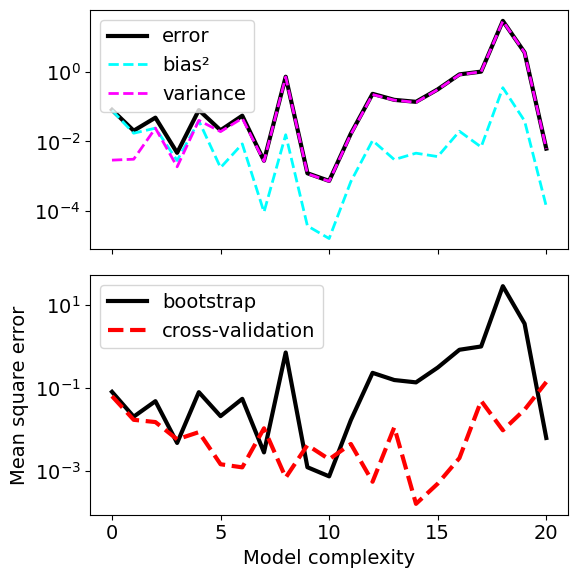

In [151]:
ax[1].plot(error_ols, "k-", lw=3, label="bootstrap")
ax[1].plot(mse_ols, 'r--', lw=3, label="cross-validation")

ax[1].set(xlabel="Model complexity", ylabel="Mean square error", yscale="log")
ax[1].legend()

fig.tight_layout()
fig

In [108]:
fig.savefig("figs/bias-variance_ols.pdf")

## Part d): Ridge Regression on the Franke function with resampling

In [19]:
lmbd = 0.001
beta_ridge = ridge_regression(X, y, lmbd)
model_ridge = X @ beta_ridge


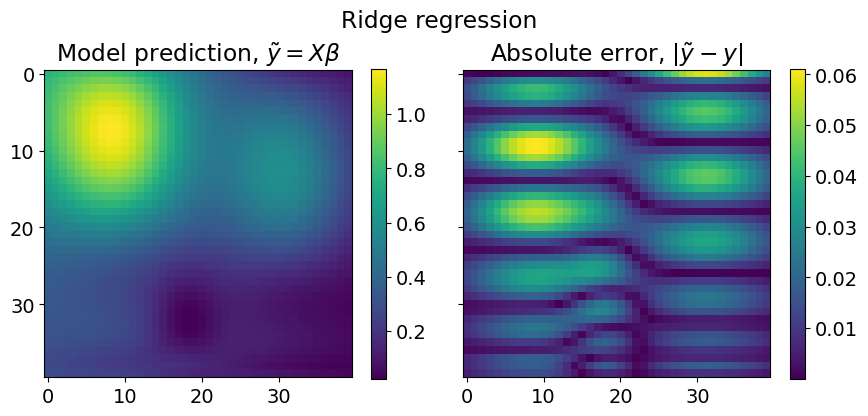

In [20]:

fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Ridge regression")
im0 = ax[0].imshow(model_ridge)
im1 = ax[1].imshow(abs(y - model_ridge))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

### Bootstrapping with Ridge regression

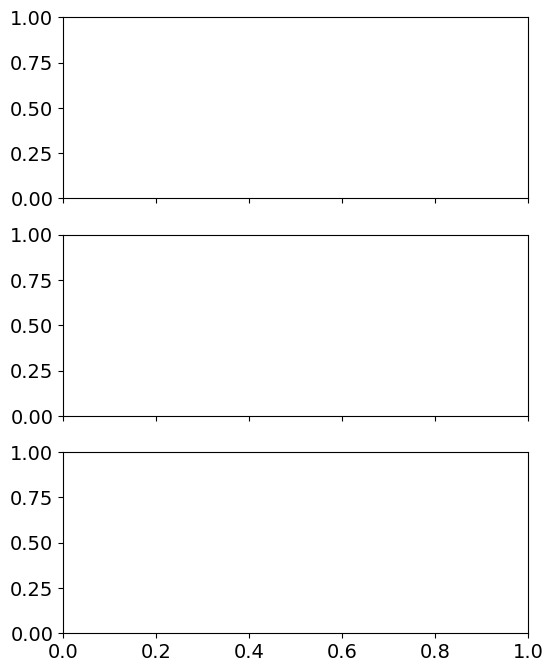

In [21]:
lmbds = np.array([1e-10, 1e-5, 1])

fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True);

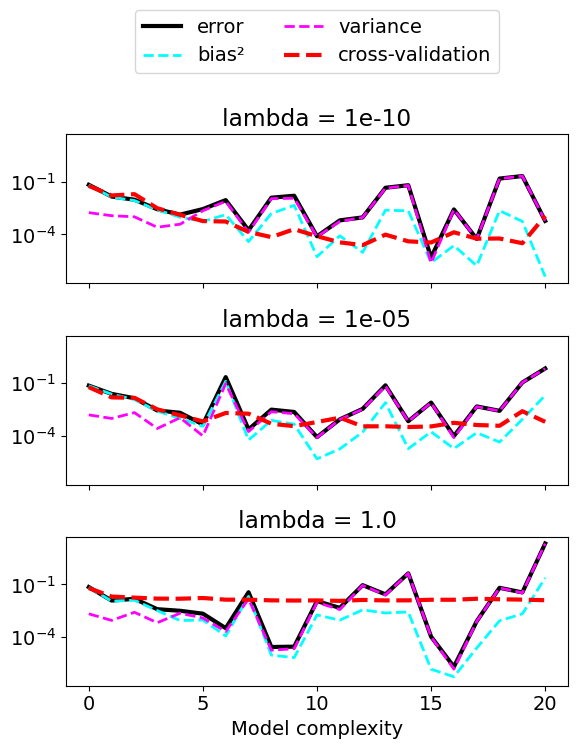

In [22]:
i = 0
for lmbd in lmbds:
    error_ridge, bias2_ridge, variance_ridge = bias_variance_tradeoff(y, arr, n_bootstraps=n_bootstraps, max_degree=max_degree, test_size=test_size, regression_method=ridge_regression, regression_params=lmbd)

    mse_ridge = np.zeros(max_degree)
    for deg in range(max_degree):
        X = DesignMatrix(arr, arr, deg)
        mse_ridge[deg] = cross_validation(X, y, test_size=test_size, regression_method=ridge_regression, regression_params=lmbd)

    ax[i].plot(error_ridge, "k-", lw=3, label="error")
    ax[i].plot(bias2_ridge, "--", color="cyan", lw=2, label="bias²")
    ax[i].plot(variance_ridge, "--", color="magenta", lw=2, label="variance")
    ax[i].set(title="lambda = "+ str(lmbd), yscale="log")
    ax[i].plot(mse_ridge, "r--", lw=3, label="cross-validation")

    i += 1

ax[-1].set(xlabel="Model complexity");
ax[0].legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.9))

fig.tight_layout()
fig

In [23]:
fig.savefig("figs/bias-variance_ridge.pdf")

## Part e): Lasso regression

In [24]:
model_lasso = lasso_regression(X, X, y, lmbd);

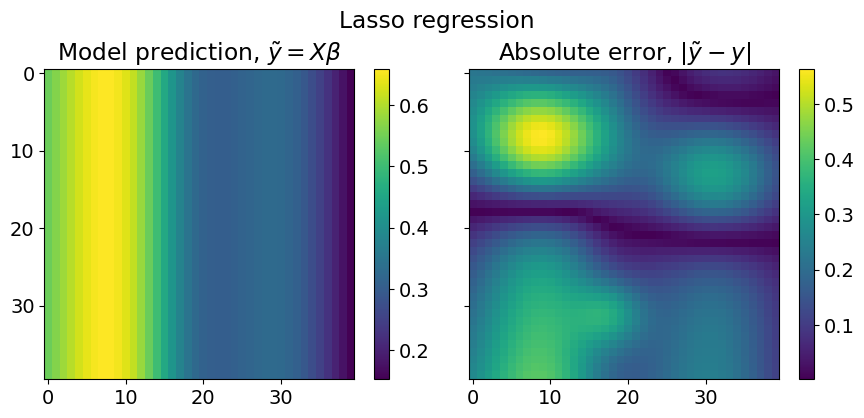

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(9,4), sharex=True, sharey=True)
fig.suptitle("Lasso regression")
im0 = ax[0].imshow(model_lasso)
im1 = ax[1].imshow(abs(y - model_lasso))

ax[0].set(title="Model prediction, " + r"$\tilde{y} = X \beta$")
ax[1].set(title=r"Absolute error, " + r"$|\tilde{y} - y|$")

fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])

fig.tight_layout()

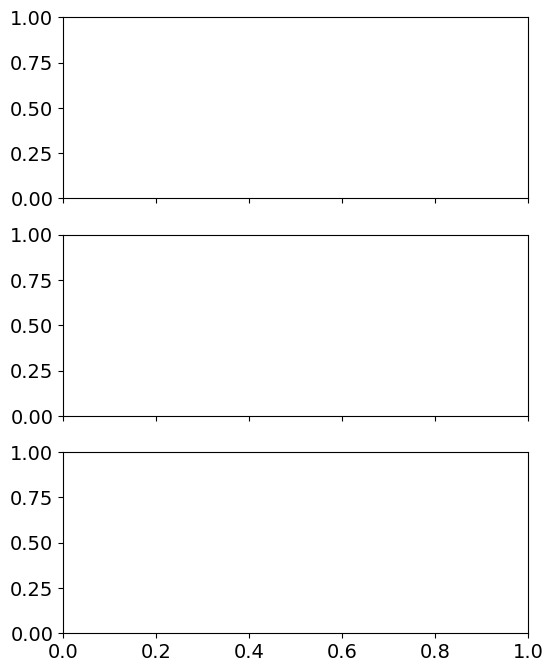

In [26]:
lmbds = np.array([1e-10, 1e-5, 1])

fig, ax = plt.subplots(3, 1, figsize=(6, 8), sharex=True, sharey=True);

### Bootstrapping with Lasso regression

/home/silja/Programs/miniconda3/envs/compsci/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.206e-02, tolerance: 1.419e-04
  model = cd_fast.enet_coordinate_descent(
/home/silja/Programs/miniconda3/envs/compsci/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-02, tolerance: 1.734e-04
  model = cd_fast.enet_coordinate_descent(
/home/silja/Programs/miniconda3/envs/compsci/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the 

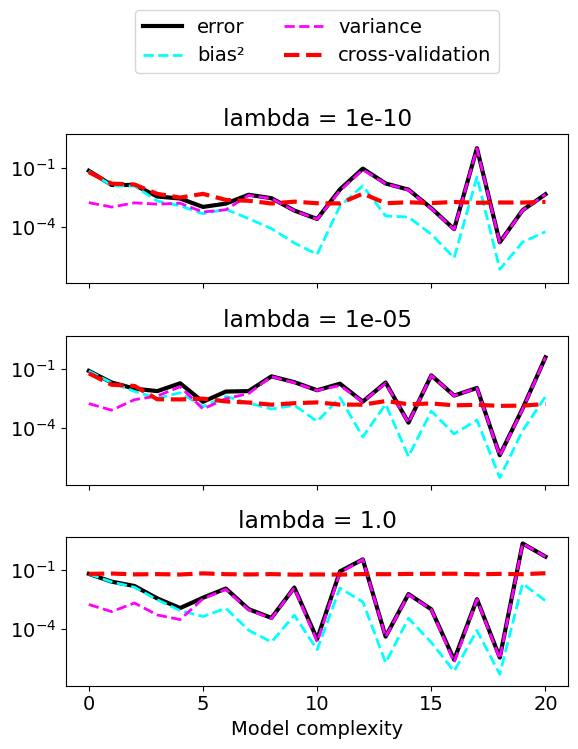

In [27]:
i = 0
for lmbd in lmbds:
    error_lasso, bias2_lasso, variance_lasso = bias_variance_tradeoff(y, arr, n_bootstraps=n_bootstraps, max_degree=max_degree, test_size=test_size, regression_method=lasso_regression, regression_params=lmbd)

    mse_lasso = np.zeros(max_degree)
    for deg in range(max_degree):
        X = DesignMatrix(arr, arr, deg)
        mse_lasso[deg] = cross_validation(X, y, test_size=test_size, regression_method=lasso_regression, regression_params=lmbd)

    ax[i].plot(error_lasso, "k-", lw=3, label="error")
    ax[i].plot(bias2_lasso, "--", color="cyan", lw=2, label="bias²")
    ax[i].plot(variance_lasso, "--", color="magenta", lw=2, label="variance")
    ax[i].set(title="lambda = "+ str(lmbd), yscale="log")
    ax[i].plot(mse_lasso, "r--", lw=3, label="cross-validation")

    i += 1

ax[-1].set(xlabel="Model complexity");
ax[0].legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.9))

fig.tight_layout()
fig

In [28]:
fig.savefig("figs/bias-variance_lasso.pdf")